# Advanced Machine Learning 1st Project
### Authors: Guilherme Cepeda - 62931, Pedro Serrano - 54853



In this first project divided in 4 parts we were given a raw dataset, and had to perform a series of tasks:
* Prepare the data
* Learn a Bayesian network from the data
* Assess the classification results when you predict the target variable
* Propose 3 examples of relevant queries (or questions) that might be answered with your
model and present the corresponding result.


In [295]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from sklearn.model_selection import train_test_split
from pgmpy.estimators import PC, MmhcEstimator
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2
import networkx as nx
from sklearn.metrics import f1_score, accuracy_score

from pgmpy.inference import VariableElimination


### Load Data 

Here we load the raw dataset into a **Dataframe**.

In [324]:
#creates a dataframe from a file
df = pd.read_csv("CHD_dataset.csv")

#info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex              4240 non-null   object 
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   object 
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   object 
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(4), object(3)
memory usage: 530.1+ KB
N

### Exploratory Data Analysis (EDA)

First we started exploring and analyzing our data, the first thing we noticed was the amount of values **NaN** in the dataset which we will address before applying the **feature selection** and learnig the **Bayesian Network** from the data.

We verified the existence of duplicated values, presented the target variable "TenYearCHD" distribution in the dataset, analyzed the correlations between the features and the target variable and in the end we also presented a plot with the 2 most correlated features with the target variable.

0
Counter({0: 3596, 1: 644})
Positive TenYearCHD corresponds to 15.188679245283017 % of the dataset.

TenYearCHD         1.000000
age                0.225408
sysBP              0.216374
prevalentHyp       0.177458
diaBP              0.145112
glucose            0.125590
BPMeds             0.087519
totChol            0.082369
BMI                0.075300
prevalentStroke    0.061823
cigsPerDay         0.057755
heartRate          0.022907
education         -0.054248
Name: TenYearCHD, dtype: float64


C:\Users\guilh\AppData\Local\Temp\ipykernel_5384\3809290972.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


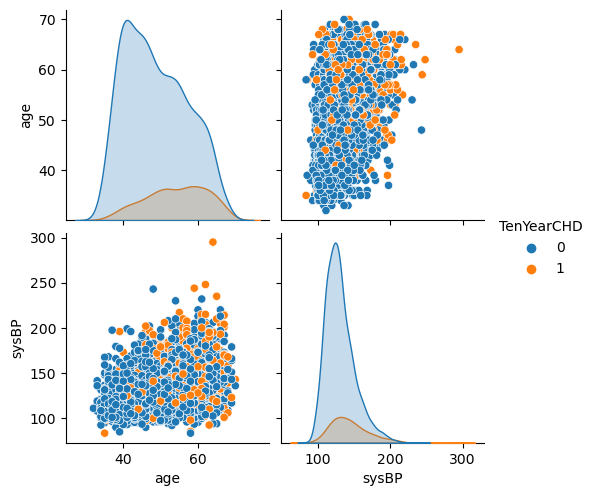

In [325]:

#check for duplicates
print(df.duplicated().sum())

# summarize TenYearCHD distribution
counter = Counter(df['TenYearCHD'])
print(counter)
print('Positive TenYearCHD corresponds to', counter[1]/(counter[0]+counter[1])*100,'% of the dataset.\n')


#creates a matrix of correlations
corr_matrix = df.corr() 
#how much each attribute correlates with the TenYearCHD target variable value, the lower the value the least relevant the feature is
print(corr_matrix["TenYearCHD"].sort_values(ascending=False))

#plot to present the correlation between the 2 most correlated features with target variable
sns.pairplot(df, vars=['age', 'sysBP'], hue='TenYearCHD')

### Splitting Dataset

Here we splitted our dataset into a training set and a test set.

In [386]:

#defining the X and y for the train test split
X = df #.iloc[:,:15]
y = df.iloc[:,15]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

X_train.info()
print("\n")
y_train.info()
print("\n")
X_test.info()
print("\n")
y_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3180 entries, 3637 to 1289
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex              3180 non-null   object 
 1   age              3180 non-null   int64  
 2   education        3102 non-null   float64
 3   currentSmoker    3180 non-null   object 
 4   cigsPerDay       3161 non-null   float64
 5   BPMeds           3144 non-null   float64
 6   prevalentStroke  3180 non-null   int64  
 7   prevalentHyp     3180 non-null   int64  
 8   diabetes         3180 non-null   object 
 9   totChol          3142 non-null   float64
 10  sysBP            3180 non-null   float64
 11  diaBP            3180 non-null   float64
 12  BMI              3167 non-null   float64
 13  heartRate        3180 non-null   float64
 14  glucose          2895 non-null   float64
 15  TenYearCHD       3180 non-null   int64  
dtypes: float64(9), int64(4), object(3)
memory usage: 422.3+ K

### Data processing

After analyzing the data, we found that had to be changed in order to perform a Bayesian Network:
* As we found a lot of **NaN** values, it wouldn't make sense to just delete or ignore them, so we used a __interpolate()__ function to estimate the value by calculating the average of the ones above and below.
* We chose to perserve the original data type of some colums.
* Given that we found several columns with non-numerical categoric data, we decided to replace those values with numerical ones.

In [332]:
#All Data processing
#interpolates the NaN values in the data and replaces the categorical values with numerical values
def data_processing(dataf,columns_to_convert):

    #using interpolate to do the mean between the previous and next values of the NaN values on the data
    dataf.interpolate(method='linear',inplace=True)
    #converting the columns to the original type
    dataf[columns_to_convert] = dataf[columns_to_convert].astype(int)
  

    #replacing the Categorical values male e female of sex to 1 and 0 accordingly
    dataf.replace('male',1, inplace = True)
    dataf.replace('female',0, inplace = True)
    #replacing the yes and no to 1 and 0 accordingly
    dataf.replace('Yes',1, inplace = True)
    dataf.replace('No',0, inplace = True)
    #checks if there is any nulls
    print(dataf.isnull().sum(),"\n")




columns_t_c = ["totChol","heartRate","glucose"]

# training data
data_processing(X_train,columns_t_c)

# testing data
data_processing(X_test,columns_t_c)



Sex                0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64 

Sex                0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64 



### Feature Selection


As recommended in the assignment we ran a **SelectKBest** model with a chi2 score function, to attempt to drop the least meaningful values. 

We chose to remove the 3 features with the lowest score:
* Education
* HeartRate
* CurrentSmoker

In [334]:
def analize_features_sel (skb, features_processed):
        # Create a dataframe with feature names, scores, and p-values
        df_score_features = pd.DataFrame({'Feature name': features_processed,
                    'Scores': skb.scores_,
                   'P-values': skb.pvalues_})

        # Sort the dataframe by the highest scores in descending order
        df_score_features = df_score_features.sort_values(by='Scores', ascending=False)

        # Print the first  rows of the dataframe
        print ("\n Feature Selection for CHD: The higher the score, the more important the feature is ")
        print(df_score_features.head(len (features_processed)))
        print ("P-values: probability that the null hypothesis is true, i.e., that the feature is not related to the target variable")
        print ("\n")



# Create a SelectKBest object with k=12 +1 because column TenYearCHD
skb = SelectKBest(chi2, k=13)

# Fit the object 
skb.fit(X_train, y_train)

# Analize feature selection results
analize_features_sel(skb, X_train.columns)

# Transform the data to include only the selected features
X_train_new = skb.transform(X_train)
X_test_new = skb.transform(X_test)

# Transform the data to include only the selected features and convert it back to a DataFrame
X_train_new_df = pd.DataFrame(X_train_new, columns=X_train.columns[skb.get_support()])
X_test_new_df = pd.DataFrame(X_test_new, columns=X_test.columns[skb.get_support()])

#prints in the original order without the features with the least score
print(X_train_new_df.info(),"\n")
print(X_test_new_df.info())


 Feature Selection for CHD: The higher the score, the more important the feature is 
       Feature name       Scores       P-values
15       TenYearCHD  2693.000000   0.000000e+00
10            sysBP   517.508256  1.474539e-114
14          glucose   322.428720   4.284297e-72
1               age   233.225206   1.180320e-52
9           totChol   183.848048   7.002984e-42
11            diaBP   121.902455   2.424709e-28
7      prevalentHyp    72.055837   2.091935e-17
4        cigsPerDay    66.252766   3.966507e-16
8          diabetes    31.788556   1.719026e-08
5            BPMeds    23.366334   1.339016e-06
12              BMI    21.135853   4.278481e-06
0               Sex    10.809392   1.009865e-03
6   prevalentStroke    10.515110   1.184024e-03
2         education     5.486726   1.916140e-02
13        heartRate     4.176450   4.098948e-02
3     currentSmoker     0.004703   9.453232e-01
P-values: probability that the null hypothesis is true, i.e., that the feature is not related to t

In [335]:
X_test_new_df

,Sex,age,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,glucose,TenYearCHD
0,1.0,52.0,0.0,0.0,0.0,1.0,0.0,196.0,126.0,80.0,22.32,74.0,0.0
1,0.0,40.0,0.0,0.0,0.0,1.0,0.0,159.0,145.0,90.0,20.33,83.0,0.0
2,1.0,57.0,0.0,0.0,0.0,0.0,0.0,207.0,111.0,80.0,37.15,70.0,0.0
3,0.0,47.0,0.0,0.0,0.0,0.0,0.0,346.0,118.5,81.0,34.56,86.0,0.0
4,1.0,40.0,30.0,0.0,0.0,0.0,0.0,202.0,112.5,64.5,22.85,103.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,0.0,53.0,0.0,0.0,0.0,0.0,0.0,213.0,133.0,89.0,17.89,73.0,0.0
1056,1.0,41.0,0.0,0.0,0.0,1.0,0.0,230.0,150.0,101.0,28.54,65.0,0.0
1057,0.0,48.0,20.0,0.0,0.0,0.0,0.0,182.0,121.0,72.0,26.39,70.0,0.0
1058,0.0,57.0,20.0,0.0,0.0,1.0,0.0,246.0,160.0,92.5,30.74,76.0,0.0


### Learn a Bayesian network from the data

After finishing the data preparation and cleaning, we can finally start learning the **Bayesian Network**.

We started by trying to achieve the best possible model to our data.

#### Defining the Best HillClimbSearch Model

Here we ran a cycle to compare different scoring methods, and chose the one with the best score to the structure for the following steps.

In [337]:

# Define a list of scoring methods
scoring_methods = [BicScore(X_train_new_df), K2Score(X_train_new_df), BDeuScore(X_train_new_df)]

best_model = None
best_score = float('-inf')


for scoring_method in scoring_methods:
    # Learn the structure using the current combination of algorithm and scoring method
    estimated_model = HillClimbSearch(X_train_new_df).estimate(scoring_method=scoring_method)

    score = scoring_method.score(estimated_model)

    print(f"Model learned by HillClimbSearch with {scoring_method} scoring:")
    print(estimated_model.edges())
    print(f"{scoring_method} score: {score}")

    # Check if this is the best model so far
    if score > best_score:
        best_score = score
        best_model = estimated_model

print("Best model found:")
print(best_model.edges())



  0%|          | 0/1000000 [00:00<?, ?it/s]

Model learned by HillClimbSearch with <pgmpy.estimators.StructureScore.BicScore object at 0x0000021AB9B91F50> scoring:
[('Sex', 'TenYearCHD'), ('cigsPerDay', 'Sex'), ('BPMeds', 'prevalentHyp'), ('prevalentHyp', 'diaBP'), ('prevalentHyp', 'sysBP'), ('prevalentHyp', 'TenYearCHD'), ('prevalentHyp', 'age'), ('prevalentHyp', 'prevalentStroke'), ('TenYearCHD', 'diabetes')]
<pgmpy.estimators.StructureScore.BicScore object at 0x0000021AB9B91F50> score: -109928.70923681263


  0%|          | 0/1000000 [00:00<?, ?it/s]

Model learned by HillClimbSearch with <pgmpy.estimators.StructureScore.K2Score object at 0x0000021AB9B25650> scoring:
[('Sex', 'BMI'), ('Sex', 'TenYearCHD'), ('cigsPerDay', 'Sex'), ('BPMeds', 'prevalentStroke'), ('BPMeds', 'totChol'), ('BPMeds', 'Sex'), ('prevalentStroke', 'BMI'), ('prevalentHyp', 'diaBP'), ('prevalentHyp', 'BPMeds'), ('prevalentHyp', 'age'), ('prevalentHyp', 'TenYearCHD'), ('diabetes', 'glucose'), ('diabetes', 'BMI'), ('sysBP', 'prevalentHyp'), ('sysBP', 'BMI'), ('TenYearCHD', 'diabetes')]
<pgmpy.estimators.StructureScore.K2Score object at 0x0000021AB9B25650> score: -102996.80187966049


  0%|          | 0/1000000 [00:00<?, ?it/s]

Model learned by HillClimbSearch with <pgmpy.estimators.StructureScore.BDeuScore object at 0x0000021AB9807650> scoring:
[('Sex', 'TenYearCHD'), ('Sex', 'BPMeds'), ('cigsPerDay', 'Sex'), ('BPMeds', 'prevalentStroke'), ('prevalentHyp', 'sysBP'), ('prevalentHyp', 'diaBP'), ('prevalentHyp', 'BPMeds'), ('prevalentHyp', 'age'), ('diabetes', 'TenYearCHD'), ('diabetes', 'prevalentHyp'), ('glucose', 'diabetes'), ('TenYearCHD', 'prevalentHyp'), ('TenYearCHD', 'prevalentStroke')]
<pgmpy.estimators.StructureScore.BDeuScore object at 0x0000021AB9807650> score: -108638.44005887228
Best model found:
[('Sex', 'BMI'), ('Sex', 'TenYearCHD'), ('cigsPerDay', 'Sex'), ('BPMeds', 'prevalentStroke'), ('BPMeds', 'totChol'), ('BPMeds', 'Sex'), ('prevalentStroke', 'BMI'), ('prevalentHyp', 'diaBP'), ('prevalentHyp', 'BPMeds'), ('prevalentHyp', 'age'), ('prevalentHyp', 'TenYearCHD'), ('diabetes', 'glucose'), ('diabetes', 'BMI'), ('sysBP', 'prevalentHyp'), ('sysBP', 'BMI'), ('TenYearCHD', 'diabetes')]


#### Calculating CPDs from the Bayesian Network

After obtaining the best struture we created our Bayesian Network with it, we added the CPDs using the **MaximumLikelihoodEstimator** and proceeded with our work.

Later we tried to run some queries and we found that some nodes were missing and had to add them manually.

In [338]:
model = BayesianNetwork(best_model.edges())

#Estimate the parameters of the model using maximum likelihood estimation
mle = MaximumLikelihoodEstimator(model, X_train_new_df)


nodes = model.nodes()
#needed to add some specific nodes
node_to_add = 'Sex'
model.add_node(node_to_add)

node_to_add = 'totChol'
model.add_node(node_to_add)

print(f"\n\n Nodes: {nodes}\n\n")

# Print the CPDs of the model
for cpd in mle.get_parameters():
    
    # Associating the CPDs with the network
    model.add_cpds(cpd)
    print(cpd)

model.get_cpds()





 Nodes: ['Sex', 'BMI', 'TenYearCHD', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'totChol', 'prevalentHyp', 'diaBP', 'age', 'diabetes', 'glucose', 'sysBP']


+------------+---------------------+-----+------------------+
| BPMeds     | BPMeds(0.0)         | ... | BPMeds(1.0)      |
+------------+---------------------+-----+------------------+
| cigsPerDay | cigsPerDay(0.0)     | ... | cigsPerDay(60.0) |
+------------+---------------------+-----+------------------+
| Sex(0.0)   | 0.6503541532517708  | ... | 0.5              |
+------------+---------------------+-----+------------------+
| Sex(1.0)   | 0.34964584674822924 | ... | 0.5              |
+------------+---------------------+-----+------------------+
+-------------------------+-----+-----------------------+
| Sex                     | ... | Sex(1.0)              |
+-------------------------+-----+-----------------------+
| diabetes                | ... | diabetes(1.0)         |
+-------------------------+-----+------------------

'# Print the CPDs of the model\nfor cpd in mle.get_parameters():\n    print(cpd)\n'

#### Learning the parameters


Here we fitted the model with our training data and the **MaximumLikelihoodEstimator** estimator.

In [339]:
model.fit(X_train_new_df, estimator=MaximumLikelihoodEstimator)    

#### Model Validation

Now that we have our Bayesian Network completed, its time to run some tests.

We tested 4 different queries with the **VariableElimination** inference model:
* An absurd high probability case
* A "normal" case
* A observation with lowest possible values, which to another probability case
* And we brought the "normal" case again and altered the "sysBP" value to a higher value, as this feature is highly correlated with the target variable, to prove that the probability would increase

In [384]:

# Perform inference and make predictions on the test set
inference = VariableElimination(model)

array_of_evidences = []

# absurd high probability case
array_of_evidences.append({'Sex': 0, 'totChol': 600, 'sysBP': 295, 'diaBP': 140, 'BMI': 56.8})

# normal case weak probability of having CHD in 10 years
array_of_evidences.append({'Sex': 1, 'totChol': 155, 'sysBP': 106, 'diaBP': 60, 'BMI': 22.19 , 'glucose': 66})

# lowest possible values
array_of_evidences.append({'totChol': 113, 'sysBP': 83.5, 'diaBP': 50 , 'glucose': 40})# works

# normal case with max sysBP should increase probability
array_of_evidences.append({'Sex': 1, 'totChol': 155, 'sysBP': 295, 'diaBP': 60, 'BMI': 22.19 , 'glucose': 66})

for i in array_of_evidences:
    predicted = inference.query(variables=['TenYearCHD'], evidence=i)
    print(predicted)




+-----------------+-------------------+
| TenYearCHD      |   phi(TenYearCHD) |
+=================+===================+
| TenYearCHD(0.0) |            0.5359 |
+-----------------+-------------------+
| TenYearCHD(1.0) |            0.4641 |
+-----------------+-------------------+
+-----------------+-------------------+
| TenYearCHD      |   phi(TenYearCHD) |
+=================+===================+
| TenYearCHD(0.0) |            0.8577 |
+-----------------+-------------------+
| TenYearCHD(1.0) |            0.1423 |
+-----------------+-------------------+
+-----------------+-------------------+
| TenYearCHD      |   phi(TenYearCHD) |
+=================+===================+
| TenYearCHD(0.0) |            0.8949 |
+-----------------+-------------------+
| TenYearCHD(1.0) |            0.1051 |
+-----------------+-------------------+
+-----------------+-------------------+
| TenYearCHD      |   phi(TenYearCHD) |
+=================+===================+
| TenYearCHD(0.0) |            0.7309 |


#### Model Evaluation

Here we evaluate the Bayesian Network with the test dataset.

We noticed that the test dataset had some data cleaning issues.

In [388]:
#model evaluation with accuracy score

print(X_test_new_df.info())

# change the data type to int
X_test_new_df['cigsPerDay'] = X_test_new_df['cigsPerDay'].apply(int)
X_test_new_df['diabetes'] = X_test_new_df['diabetes'].apply(int)
X_test_new_df['totChol'] = X_test_new_df['totChol'].apply(int)
X_test_new_df['glucose'] = X_test_new_df['glucose'].apply(int)
X_test_new_df['age'] = X_test_new_df['age'].apply(int)
X_test_new_df['prevalentHyp'] = X_test_new_df['prevalentHyp'].apply(int)
X_test_new_df['sysBP'] = X_test_new_df['sysBP'].apply(int)
X_test_new_df['diaBP'] = X_test_new_df['diaBP'].apply(int)

#makes the prediction with the x_test dataset and compare it with the y_test 
predicted_labels = model.predict(X_test_new_df.drop('TenYearCHD', axis=1))
true_labels = X_test_new_df['TenYearCHD']
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex              1060 non-null   float64
 1   age              1060 non-null   float64
 2   cigsPerDay       1060 non-null   float64
 3   BPMeds           1060 non-null   float64
 4   prevalentStroke  1060 non-null   float64
 5   prevalentHyp     1060 non-null   float64
 6   diabetes         1060 non-null   float64
 7   totChol          1060 non-null   float64
 8   sysBP            1060 non-null   float64
 9   diaBP            1060 non-null   float64
 10  BMI              1060 non-null   float64
 11  glucose          1060 non-null   float64
 12  TenYearCHD       1060 non-null   float64
dtypes: float64(13)
memory usage: 107.8 KB
None


  0%|          | 0/1060 [00:00<?, ?it/s]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices